In [1]:
import itertools
import time

import numpy.random as random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from keras.models import Sequential
from keras.layers import Dense
from keras import activations, optimizers, regularizers, losses, initializers
from functools import partial
from sklearn.utils import shuffle

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)


def display_as_DF(a):
    display(pd.DataFrame(a))

In [2]:
def calc_weights(X):
    W = X.T @ X  # row dot column
    np.fill_diagonal(W, 0)
    assert W.shape == (X.shape[1], X.shape[1])
    return W


def sign(x):
    s = x.copy()
    s[s >= 0] = 1
    s[s < 0] = -1
    return s


def synchronous_update(X, W):
    tmp = W @ X.T  # W row * X column
    new_X = sign(tmp)
    return new_X.T


def asynchronous_update(X, W):
    new_X = np.atleast_2d(X.copy())

    for i in range(new_X.shape[1]):  #update column after column
        update_i = W[i] @ new_X.T
        new_X[:, i] = sign(update_i).T

    return new_X


def random_asynchronous_update(X, W):
    new_X = np.atleast_2d(X.copy())

    for _ in range(new_X.shape[1]):  #update column after column
        rnd = np.random.randint(low=0, high=new_X.shape[1])
        update_i = W[rnd] @ new_X.T
        new_X[:, rnd] = sign(update_i).T
    return new_X


def recall_synchronous(probe, W, max_iter=1000):
    last, last_last = 0, 0

    for i in range(max_iter):
        probe = synchronous_update(probe, W)

        if test_equality(probe, last) or test_equality(probe, last_last):
            print("Converged after iterations", i + 1)
            return probe
        last_last = last
        last = probe

    print("Failed! Did not converge after iteration", max_iter)
    return probe


def recall_asynchronous(probe, W, max_iter=1000):  #online
    last, last_last = 0, 0
    probe = np.atleast_2d(probe)

    energy = [energy_function_fast(W, probe[0,:])]  #cannot handle probe.ndim > 1

    for i in range(max_iter):
        probe = asynchronous_update(probe, W)

        energy.append(energy_function_fast(W, probe[0,:]))

        if test_equality(probe, last) or test_equality(probe, last_last):
            print("Converged after iterations", i + 1)
            return probe, energy
        last_last = last
        last = probe

    print("Failed! Did not converge after iteration", max_iter)
    return probe, energy


def recall_random_asynchronous(probe, W, max_iter=1000):
    last, last_last = 0, 0

    for i in range(max_iter):
        probe = random_asynchronous_update(probe, W)

        if test_equality(probe, last) or test_equality(probe, last_last):
            print("Converged after iterations", i + 1)
            return probe
        last_last = last
        last = probe

    print("Failed! Did not converge after iteration", max_iter)
    return probe


def test_equality(a, b):
    return np.all(a == b)


def show(x):
    plt.imshow(x.reshape(32, 32))
    plt.show()


def find_pattern_and_return_index(patterns, p):
    try:
        return np.argwhere((p == patterns).all(1))[0, 0]
    except:
        print("Could not find pattern!")


def energy_function_for_loop(W, x):
    assert x.ndim == 1
    e = 0
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            e += W[i, j] * x[i] * x[j]
    return -e


def energy_function_fast(W, x):  #equivalent with loop but way faster
    assert x.ndim <= 2
    c_vec = x.reshape(-1, 1)  # accepts only one sample
    e = -np.sum(W @ c_vec * c_vec)
    return e


# 3.1 Convergence and attractors

In [3]:
x1 = [-1, -1, 1, -1, 1, -1, -1, 1]
x2 = [-1, -1, -1, -1, -1, 1, -1, -1]
x3 = [-1, 1, 1, -1, -1, 1, -1, 1]

X_sync = np.row_stack((x1, x2, x3))
display_as_DF(X_sync)

W = calc_weights(X_sync)
display_as_DF(W)

,0,1,2,3,4,5,6,7
0,-1,-1,1,-1,1,-1,-1,1
1,-1,-1,-1,-1,-1,1,-1,-1
2,-1,1,1,-1,-1,1,-1,1


,0,1,2,3,4,5,6,7
0,0,1,-1,3,1,-1,3,-1
1,1,0,1,1,-1,1,1,1
2,-1,1,0,-1,1,-1,-1,3
3,3,1,-1,0,1,-1,3,-1
4,1,-1,1,1,0,-3,1,1
5,-1,1,-1,-1,-3,0,-1,-1
6,3,1,-1,3,1,-1,0,-1
7,-1,1,3,-1,1,-1,-1,0


In [4]:
memory = recall_synchronous(X_sync, W)

display_as_DF(X_sync)
display_as_DF(memory)

Converged after iterations 2


,0,1,2,3,4,5,6,7
0,-1,-1,1,-1,1,-1,-1,1
1,-1,-1,-1,-1,-1,1,-1,-1
2,-1,1,1,-1,-1,1,-1,1


,0,1,2,3,4,5,6,7
0,-1,-1,1,-1,1,-1,-1,1
1,-1,-1,-1,-1,-1,1,-1,-1
2,-1,1,1,-1,-1,1,-1,1


In [5]:

x1d = [1, -1, 1, -1, 1, -1, -1, 1]
x2d = [1, 1, -1, -1, -1, 1, -1, -1]
x3d = [1, 1, 1, -1, 1, 1, -1, 1]
X_sync_distorted = np.row_stack((x1d, x2d, x3d))
display_as_DF(X_sync_distorted)

memory = recall_synchronous(X_sync_distorted, W)
display_as_DF(memory)

display_as_DF(X_sync)

,0,1,2,3,4,5,6,7
0,1,-1,1,-1,1,-1,-1,1
1,1,1,-1,-1,-1,1,-1,-1
2,1,1,1,-1,1,1,-1,1


Converged after iterations 4


,0,1,2,3,4,5,6,7
0,-1,-1,1,-1,1,-1,-1,1
1,1,1,-1,-1,-1,1,-1,-1
2,-1,-1,1,-1,1,1,-1,1


,0,1,2,3,4,5,6,7
0,-1,-1,1,-1,1,-1,-1,1
1,-1,-1,-1,-1,-1,1,-1,-1
2,-1,1,1,-1,-1,1,-1,1


In [6]:
combinations = pd.DataFrame(
    itertools.product((-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1))).values
display_as_DF(combinations)

memory = recall_synchronous(combinations, W)

#display_as_DF(memory)

reduced = np.unique(memory, axis=0)
print("Stable points ", len(reduced))
display_as_DF(reduced)


,0,1,2,3,4,5,6,7
0,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,1
2,-1,-1,-1,-1,-1,-1,1,-1
3,-1,-1,-1,-1,-1,-1,1,1
4,-1,-1,-1,-1,-1,1,-1,-1
...,...,...,...,...,...,...,...,...
251,1,1,1,1,1,-1,1,1
252,1,1,1,1,1,1,-1,-1
253,1,1,1,1,1,1,-1,1
254,1,1,1,1,1,1,1,-1


Converged after iterations 5
Stable points  64


,0,1,2,3,4,5,6,7
0,-1,-1,-1,-1,-1,-1,-1,1
1,-1,-1,-1,-1,-1,1,-1,-1
2,-1,-1,-1,-1,-1,1,-1,1
3,-1,-1,-1,-1,1,1,-1,1
4,-1,-1,-1,1,-1,-1,1,1
...,...,...,...,...,...,...,...,...
59,1,1,1,-1,1,1,-1,-1
60,1,1,1,1,-1,-1,1,-1
61,1,1,1,1,1,-1,1,-1
62,1,1,1,1,1,-1,1,1


In [7]:

x1d = [1, 1, -1, 1, -1, -1, -1, 1]
x2d = [1, 1, 1, 1, 1, -1, -1, -1]
x3d = [1, -1, -1, 1, -1, -1, 1, -1]
X_sync_broken = np.row_stack((x1d, x2d, x3d))
display_as_DF(X_sync_broken)

memory = recall_synchronous(X_sync_broken, W)
display_as_DF(memory)

display_as_DF(X_sync)

np.argwhere(np.all((reduced - memory[0, :]) == 0, axis=0))

,0,1,2,3,4,5,6,7
0,1,1,-1,1,-1,-1,-1,1
1,1,1,1,1,1,-1,-1,-1
2,1,-1,-1,1,-1,-1,1,-1


Converged after iterations 4


,0,1,2,3,4,5,6,7
0,1,1,-1,1,-1,-1,1,1
1,1,1,1,1,1,-1,1,-1
2,1,1,-1,1,-1,-1,1,-1


,0,1,2,3,4,5,6,7
0,-1,-1,1,-1,1,-1,-1,1
1,-1,-1,-1,-1,-1,1,-1,-1
2,-1,1,1,-1,-1,1,-1,1


array([], shape=(0, 1), dtype=int64)

# 3.2 Sequential update

(1, 11264)


,0,1,2,3,4,...,1019,1020,1021,1022,1023
0,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1
2,1,1,1,1,1,...,1,1,1,1,1
3,1,1,1,1,1,...,1,1,1,1,1
4,1,1,1,1,1,...,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
6,1,1,1,1,1,...,-1,1,1,1,1
7,1,1,1,1,1,...,1,1,1,1,1
8,1,1,1,1,1,...,1,1,1,1,1
9,-1,-1,1,1,-1,...,1,-1,-1,-1,-1


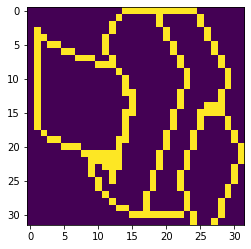

In [8]:
X = pd.read_csv("pict.dat", header=None, sep=",").values
print(X.shape)

X = X.reshape(11, 1024)
display_as_DF(X)

for i in range(len(X)):
    show(X[i])
    break  # remove to see all pics


In [9]:
three = X[:3]
W = calc_weights(three)
display_as_DF(W)

,0,1,2,3,4,...,1019,1020,1021,1022,1023
0,0,3,3,3,3,...,1,3,3,3,3
1,3,0,3,3,3,...,1,3,3,3,3
2,3,3,0,3,3,...,1,3,3,3,3
3,3,3,3,0,3,...,1,3,3,3,3
4,3,3,3,3,0,...,1,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...
1019,1,1,1,1,1,...,0,1,1,1,1
1020,3,3,3,3,3,...,1,0,3,3,3
1021,3,3,3,3,3,...,1,3,0,3,3
1022,3,3,3,3,3,...,1,3,3,0,3


In [10]:
memory, energy = recall_asynchronous(three, W)
display_as_DF(three)
display_as_DF(memory)

test_equality(memory, three)

Converged after iterations 2


,0,1,2,3,4,...,1019,1020,1021,1022,1023
0,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1
2,1,1,1,1,1,...,1,1,1,1,1


,0,1,2,3,4,...,1019,1020,1021,1022,1023
0,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1
2,1,1,1,1,1,...,1,1,1,1,1


True

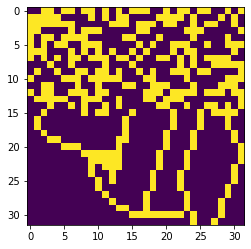

Converged after iterations 3


,0,1,2,3,4,...,1019,1020,1021,1022,1023
0,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1


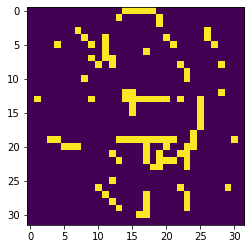

False
Could not find pattern!
Converged after iterations 2


,0
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
1019,1
1020,-1
1021,-1
1022,-1


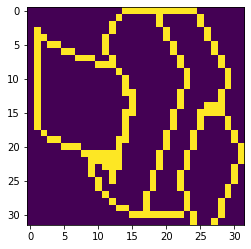

True


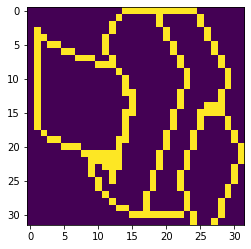

In [11]:
p10 = X[9]
show(p10)
memory, energy = recall_asynchronous(p10, W)
display_as_DF(memory)

show(memory)
print(test_equality(memory, X[0]))

index = find_pattern_and_return_index(X, memory)
if index is not None:
    show(X[index])
######################## ASYNCHONOUSLY FAILS

memory = recall_synchronous(p10, W)
display_as_DF(memory)

show(memory)
print(test_equality(memory, X[0]))

index = find_pattern_and_return_index(X, memory)
if index is not None:
    show(X[index])
########################## SYNCHONOUSLY DOES IT

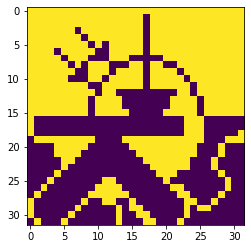

Converged after iterations 3


,0,1,2,3,4,...,1019,1020,1021,1022,1023
0,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1


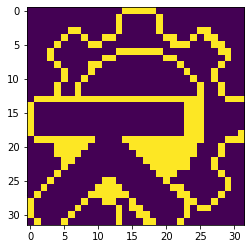

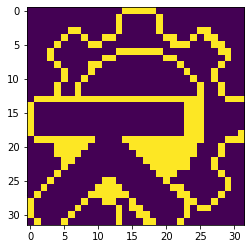

Converged after iterations 3


,0
0,1
1,1
2,1
3,1
4,1
...,...
1019,1
1020,1
1021,1
1022,1


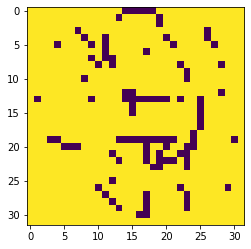

Could not find pattern!


In [12]:
p11 = X[10]
show(p11)
memory, energy = recall_asynchronous(p11, W)
display_as_DF(memory)

show(memory)
index = find_pattern_and_return_index(X, memory)
if index is not None:
    show(X[index])
########################### recall_asynchronous DOES IT

memory = recall_synchronous(p11, W)
display_as_DF(memory)

show(memory)
index = find_pattern_and_return_index(X, memory)
if index is not None:
    show(X[index])
########################### recall_synchronous FAILS (Just inverted to before :D :D :D)


# Recall random vector

,0,1,2,3,4,...,1019,1020,1021,1022,1023
0,-1.0,1.0,1.0,-1.0,-1.0,...,1.0,1.0,1.0,-1.0,-1.0


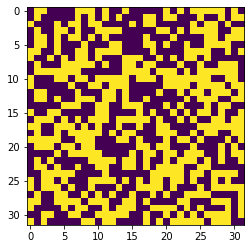

Async
Converged after iterations 3
Could not find pattern!


In [17]:
random = sign(np.random.uniform(low=-1, high=1, size=(1, 1024)))
display_as_DF(random)
show(random)

print("Async")
amemory, energy = recall_asynchronous(random, W)
index = find_pattern_and_return_index(X, amemory)
if index is not None:
    show(X[index])

In [18]:
print("\nSync")
smemory = recall_synchronous(random, W)
index = find_pattern_and_return_index(X, smemory)
if index is not None:
    show(X[index])


Sync
Converged after iterations 3
Could not find pattern!


# TEST IF ASYNCHRONOUS CAN RECALL ANYTHING -> YES, works ;)

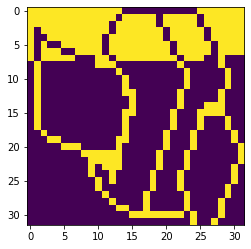

Converged after iterations 2


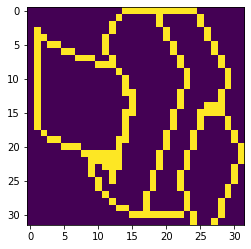

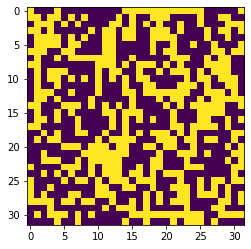

Converged after iterations 2


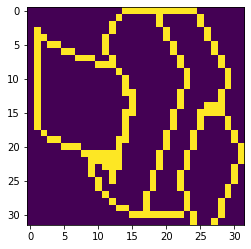

In [19]:

test = X[0].copy()
test[0:250] = -test[0:250]
show(test)
amemory, energy = recall_asynchronous(test, W)
index = find_pattern_and_return_index(X, amemory)
show(X[index])

test = X[0].copy()
test = sign(test - np.random.uniform(low=-2, high=1, size=(1, 1024)))
show(test)
amemory, energy = recall_asynchronous(test, W)
index = find_pattern_and_return_index(X, amemory)
show(X[index])

# 3.2.3 Random Asynchonous

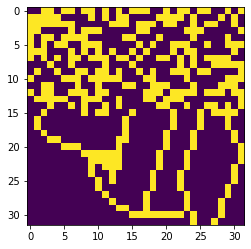

Converged after iterations 3
Could not find pattern!
Converged after iterations 7


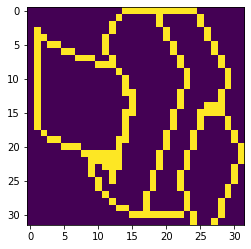

In [20]:
show(p10)

try:
    memory, energy = recall_asynchronous(p10, W)
    index = find_pattern_and_return_index(X, memory)
    show(X[index])
except:
    pass

try:
    memory = recall_random_asynchronous(p10, W)
    index = find_pattern_and_return_index(X, memory)
    show(X[index])
except:
    pass

###### only random asyn recalls most of the time

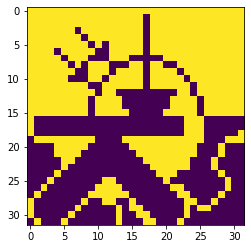

Converged after iterations 3


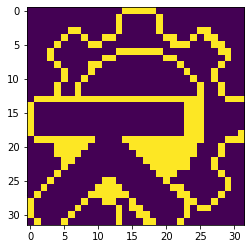

Converged after iterations 8


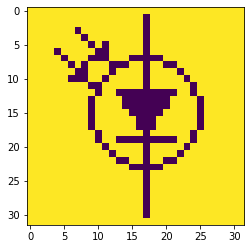

In [21]:
show(p11)

try:
    memory, energy = recall_asynchronous(p11, W)
    index = find_pattern_and_return_index(X, memory)
    show(X[index])
except:
    pass

try:
    memory = recall_random_asynchronous(p11, W)
    index = find_pattern_and_return_index(X, memory)
    show(X[index])
except:
    pass

###### both identify relative reliably one of the source patterns => BUT often the different patterns

# 3.3 Energy

In [22]:
pictures = pd.read_csv("pict.dat", header=None, sep=",").values
pictures = pictures.reshape(11, 1024)
W = calc_weights(pictures[:3])
display_as_DF(W)


,0,1,2,3,4,...,1019,1020,1021,1022,1023
0,0,3,3,3,3,...,1,3,3,3,3
1,3,0,3,3,3,...,1,3,3,3,3
2,3,3,0,3,3,...,1,3,3,3,3
3,3,3,3,0,3,...,1,3,3,3,3
4,3,3,3,3,0,...,1,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...
1019,1,1,1,1,1,...,0,1,1,1,1
1020,3,3,3,3,3,...,1,0,3,3,3
1021,3,3,3,3,3,...,1,3,0,3,3
1022,3,3,3,3,3,...,1,3,3,0,3



Image 0
Converged after iterations 2


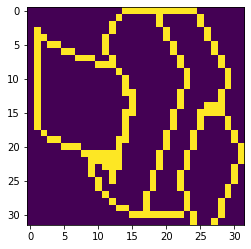

,0
0,-1470864
1,-1470864
2,-1470864


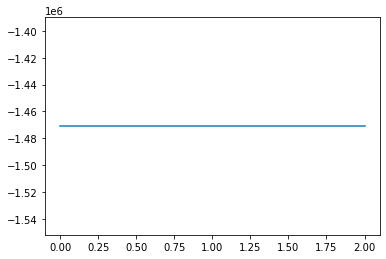


Image 1
Converged after iterations 2


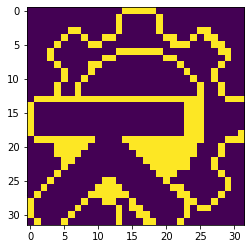

,0
0,-1395344
1,-1395344
2,-1395344


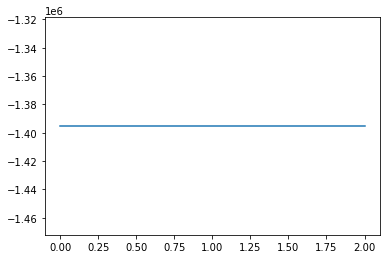


Image 2
Converged after iterations 2


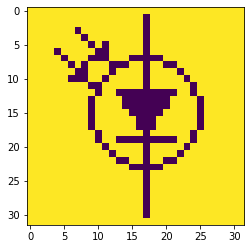

,0
0,-1494272
1,-1494272
2,-1494272


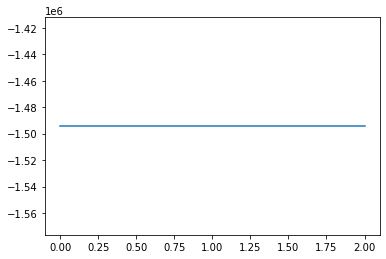


Image 3
Converged after iterations 2
Could not find pattern!


,0
0,-734700
1,-1631244
2,-1631244


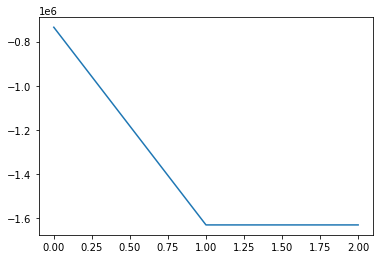


Image 4
Converged after iterations 2
Could not find pattern!


,0
0,-535440
1,-1631244
2,-1631244


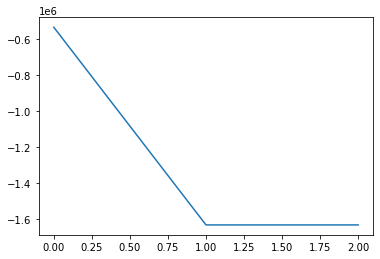


Image 5
Converged after iterations 2
Could not find pattern!


,0
0,-696624
1,-1631244
2,-1631244


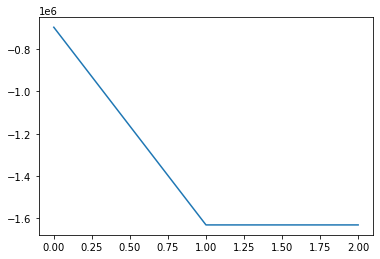


Image 6
Converged after iterations 2
Could not find pattern!


,0
0,-699116
1,-1631244
2,-1631244


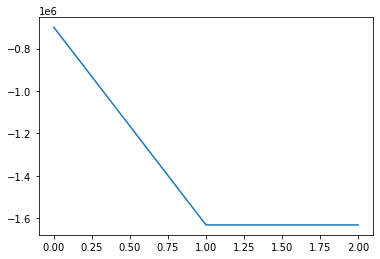


Image 7
Converged after iterations 2
Could not find pattern!


,0
0,-172592
1,-1631244
2,-1631244


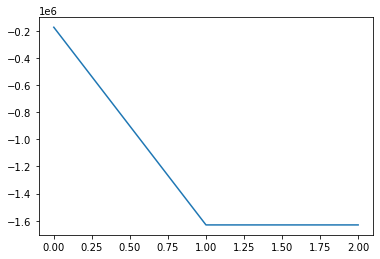


Image 8
Converged after iterations 2
Could not find pattern!


,0
0,-270860
1,-1631244
2,-1631244


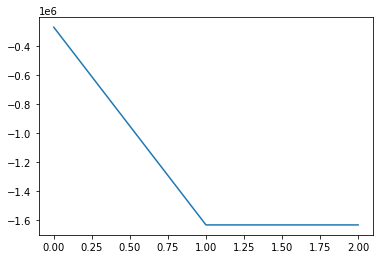


Image 9
Converged after iterations 3
Could not find pattern!


,0
0,-422892
1,-1606944
2,-1631244
3,-1631244


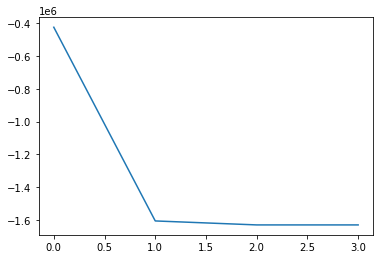


Image 10
Converged after iterations 3


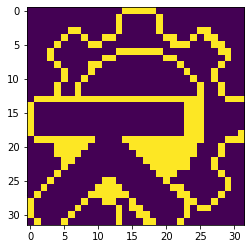

,0
0,-174592
1,-776396
2,-1395344
3,-1395344


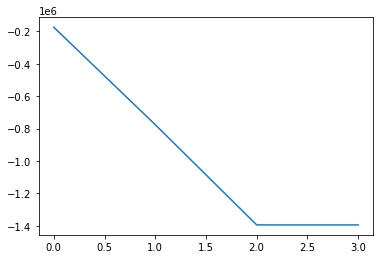

In [24]:
for i in range(len(pictures)):
    print("\nImage", i)
    memory, energy = recall_asynchronous(pictures[i], W)
    #display_as_DF(memory)

    index = find_pattern_and_return_index(X, memory)
    if index is not None:
        show(pictures[index])

    display_as_DF(energy)

    plt.plot(range(len(energy)), energy)
    plt.show()


# 3.3.4 Random weight matrix and rnd probe

Failed! Did not converge after iteration 100
Could not find pattern!


,0
0,3440.0
1,-12204.0
2,-12852.0
3,-14464.0
4,-14056.0
...,...
96,-13948.0
97,-16052.0
98,-14276.0
99,-12140.0


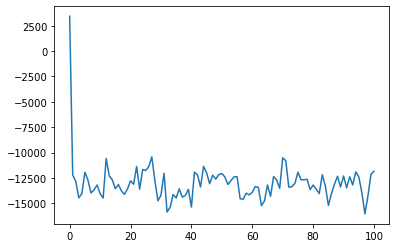

In [28]:
dim = 1024
W = sign(np.random.uniform(low=-1, high=1, size=(dim, dim)))
probe = sign(np.random.uniform(low=-1, high=1, size=(1, dim)))

memory, energy = recall_asynchronous(probe, W, max_iter=100)


index = find_pattern_and_return_index(X, memory)
if index is not None:
    show(pictures[index])

display_as_DF(energy)

plt.plot(range(len(energy)), energy)
plt.show()


# 3.3.5 random symmetric weight matrix

,0,1,2,3,4,...,1019,1020,1021,1022,1023
0,-1.0,-1.0,0.0,-1.0,0.0,...,-1.0,0.0,1.0,0.0,1.0
1,-1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,-1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-1.0,1.0,-1.0
3,-1.0,0.0,0.0,-1.0,0.0,...,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,-1.0,...,0.0,-1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1019,-1.0,1.0,0.0,0.0,0.0,...,-1.0,0.0,1.0,1.0,-1.0
1020,0.0,0.0,0.0,1.0,-1.0,...,0.0,-1.0,0.0,0.0,0.0
1021,1.0,-1.0,-1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0
1022,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,-1.0,1.0


Is sym_W symmetric? True
Converged after iterations 21
Could not find pattern!


,0
0,3440.0
1,-22480.0
2,-26904.0
3,-29256.0
4,-29928.0
...,...
17,-32632.0
18,-32668.0
19,-32684.0
20,-32684.0


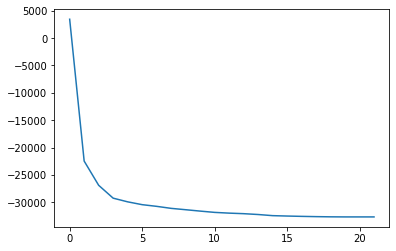

In [34]:
sym_W = 0.5 * (W + W.T)
display_as_DF(sym_W)

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

print("Is sym_W symmetric?", check_symmetric(sym_W))


memory, energy = recall_asynchronous(probe, sym_W, max_iter=100)


index = find_pattern_and_return_index(X, memory)
if index is not None:
    show(pictures[index])

display_as_DF(energy)

plt.plot(range(len(energy)), energy)
plt.show()


# 3.4 Distortion Resistance